# What are diffusion models?

A diffusion model is a neural network that learns to add and remove noise to images.

This consists of two core steps:
* forward process: we gradually $\textit{add}$ noise starting from an actual image and ending with pure noise
* reverse process: we gradually $\textit{remove}$ noise starting from pure noise and ending with an actual image

## Forward Pass 

When we add noise to images we do it in $T$ steps. We start with $x_0$, our original image. $x_1$ means we've added noise once, $x_2$ means we've added noise twice, and $x_t$ means we've added noise $t$ times.

What's the best way to model this mathematically?

Ho decided to model each transition from $x_{t-1}$ to $x_t$ with a a multivariate Gaussian distribution:
$$
q(x_t | x_{t-1})
=
N(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t I)
$$
This seems like an aribtary decision but we'll see that Gaussians have nice properties that we'll want to take advantage of later.

To create noisy image $x_t$, we only need access the previous noisy image $x_{t-1}$ -- we don't need any of $x_{t-2}, ..., x_0$. So this is a Markovian process! Mathematically:
$$
q(x_t | x_{0:t-1}) = q(x_t | q_{t-1})
$$
where $x_{0:t-1}$ means $x_0, x_1, ..., x_{t-1}$.

Remember the forward pass starts with the original image $x_0$ and generates a sequence of $T$ progressively noisier and noisier images $x_1, ..., x_T$. To generate a sequence of these $T$ images, we want a probability distribution that tells us "hey, given your original image $x_0$, there is a good chance you end up with this noisy sequence $x_{1:T}$" or perhaps "there is a low chance you end up with the sequence of images $x'_{1:T}$". Such a distribution let's us generate a sequence of noisy images $x_{1:T}$ that have the appropriate kind of and amount of noise. Mathematically, we are interested in the joint distribution conditioned on the original image:
$$
q(x_{1:T} | x_0)
$$
But how do we actually compute this?
$$
\begin{align*}
q(x_{1:T} | x_0)
&=
q(x_1 | x_0)
\times
q(x_2 | x_1, x_0) 
\times 
q(x_3 | x_2, x_1, x_0)
\times
...
\times 
q(x_T | x_{T-1}, ..., x_1, x_0)
&
\text{by the chain rule of probability}
\\
&=
\prod_{t=1}^T
q(x_t | x_{0:{t-1}}) 
\\
&=
\prod_{t=1}^T q(x_t | x_{t-1})
&
\text{by the Markovian assumption}
\end{align*}
$$
The last term $q(x_t | x_{t-1})$ is just the Gaussian multivariate that we already know how to compute!

These equations are referenced in the paper:


Small Remarks:
1. The $\beta_t$'s determine how much noise we add and are pre-defined, chosen by the user.
2. We choose to make the mean of $x_t$ the mean of $x_{t-1}$ scaled by $\sqrt{1 - \beta_t}$. The choice of $\sqrt{1 - \beta_t}$ allows the math to work out nicely. 
3. We choose to make the variance of $x_t$ simply $\beta_t I$. Again, this is a modeling choice and was done for simplicity. Note that unlike the mean, the variance does not depend directly on the previous image $x_{t-1}$.
3. Because we are adding Gaussian noise over and over again, if we do it for long enough ($T$ is sufficiently large), the final state $x_T$ should itself resemble a Gaussian distribution.
4. To actually compute the expression $N(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t I)$ on a computer we sample $\epsilon \sim N(0, 1)^d$ as a $d$-dimensional standard normal and then do
$x_t = \sqrt{1 - \beta_t} + \sqrt{\beta_t} * \epsilon.$
Remember, to change the variance of a normal variable, you multiply it by the square root of the value and to change the mean, you add that value to it.
5. Why did Ho make this normal? Because the normal distribution has this amazing "reparameterization" properties that we want to take advantage of to make our computation faster/easier. (More on this later.) Also, because in the real-world many objects actually do have a normal distribution.
6.  Why is this Markovian? Adding noise in step $t$ only really depends on the previously noised image $x_{t-1}$. How ever much noise we added to get image $x_{t-2}$ is irrelvant to $x_{t}$ since we already captured the noise from $x_{t-2}$ when we have the image $x_{t-1}$.

Let's code up the forward pass with a single image.

Here is an image of me after finding the perfect learning rate:

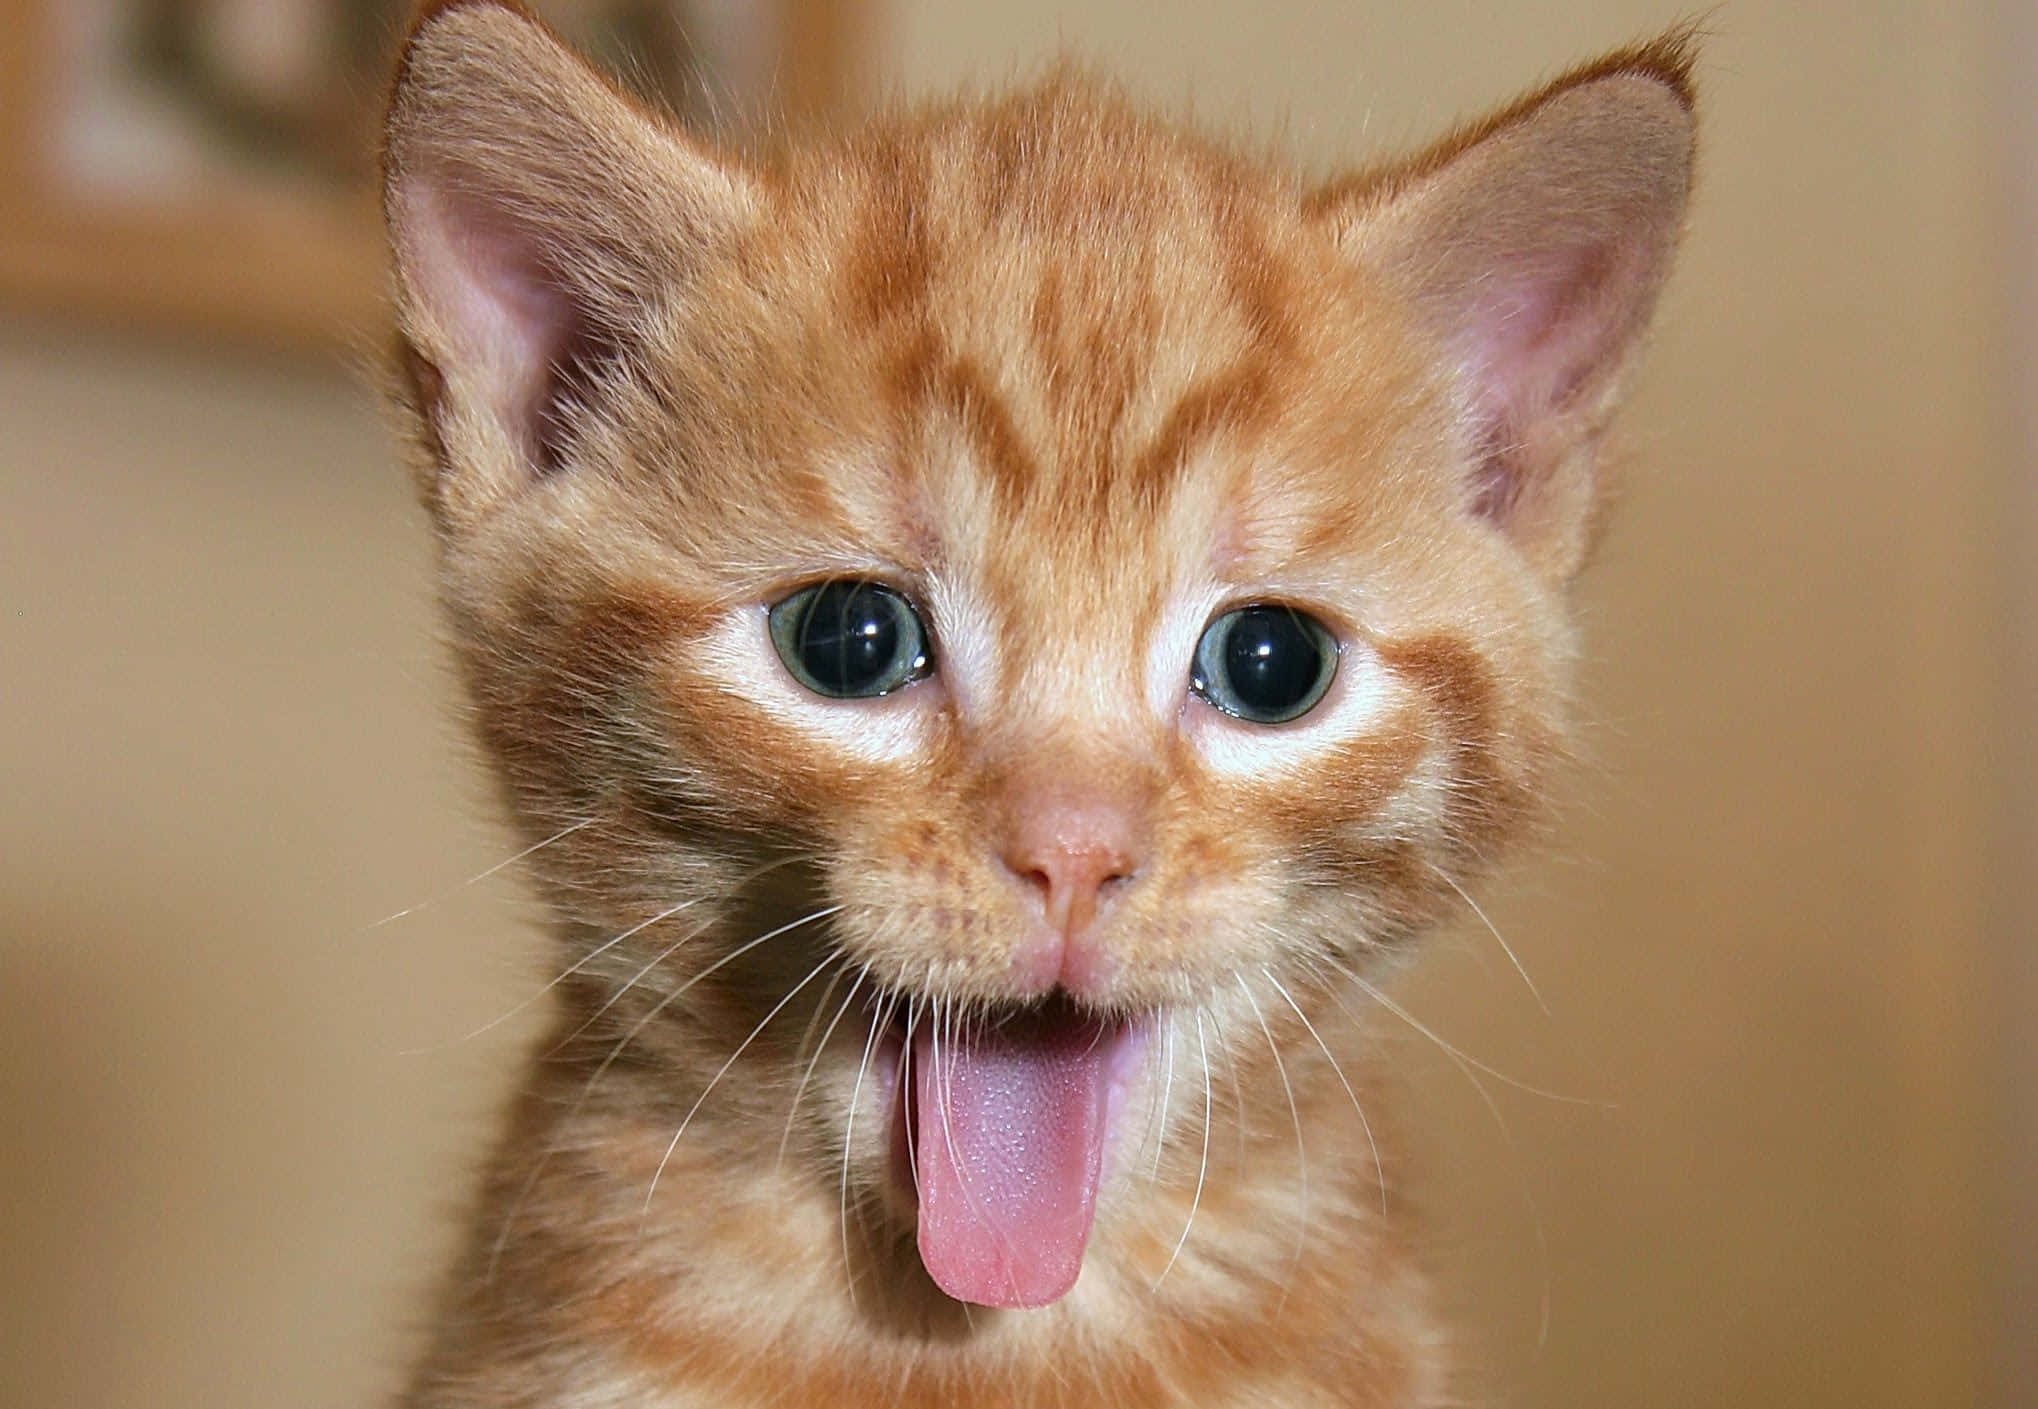

In [14]:
from PIL import Image
img = Image.open("static/cat.jpg").convert('RGB')
img

Now let's write the forward pass

In [ ]:
from tinygrad import Tensor

def _step(x_t:Tensor, beta: Tensor):
    noise = Tensor.randn(x_t.shape)
    var_coeff = beta
    mean_coeff = (1 - beta).sqrt()
    return mean_coeff + var_coeff.sqrt() * noise

def forward(x_0: Tensor, betas: Tensor):
    xs = [x_0]
    for beta in betas: xs += [_step(xs[-1], beta)]
    return xs

Let's apply the forward pass to our image

In [ ]:
from tinygrad import Tensor, dtypes
from PIL import Image

# for now, ignore how we compute the betas
betas = Tensor.linspace(0.0001, 0.02, 1000)

def img_to_tensor(img:Image) -> Tensor: return Tensor(list(img.getdata())).reshape(*img.size, 3)  # (w, h, c)
def tensor_to_img(x:Tensor) -> Image: return Image.frombytes("RGB", x.shape[:2], x.flatten(2).cast(dtypes.uint8).numpy().tobytes())

noisy_images = forward(img_to_tensor(img), betas)

((2038, 1409), (2038, 1409, 3), (2038, 1409))

and to noise an image $T$ times, go from $x_0$ to $x_T$, we do

Let's try it out on an image

In [ ]:
# TODO: run forward on an image

But, this is rather slow because we need to call forward_process_step $T$ different times. Can we do this any faster?

Ho. et al found a clever trick to do the forward process in a single computation, no need to iterate.

## Reverse Process

Great, we have the quantity $q(x_t | x_{t-1})$. Who cares?

The quantity $q(x_t | x_{t-1})$ itself is not so interesting but the closely related $q(x_{t-1} | x_t)$ is hugely important!

$q(x_t | x_{t-1})$ is the forward process and the $q(x_{t-1} | x_t)$ process because 

If we can sample from $q(x_{t-1} | x_t)$, we will be able to recreate the true sample from a Gaussian noise input $x_T \sim N(0, 1)$ (see small remark 3).

$q(x_1:T | x_0)$ tells us that given an original image $x_0$, how likely is it for us to have this particular sequence of noised images. That's cool, but not so useful. The quantity we really care about is $q(x_{t-1} | x_t)$. This tells us how to go from noisy images $x_t$ to less noisy images $x_{t-1}$. If we know the probability distribution of $q(x_{t-1} | x_t)$, then simply plug an image of pure noise for $x_T$ and $q(x_{t-1} | x_t)$ will tell us which of the millions of variations of $x_T$ have the great chance of being "less" noisy. To us all of these "less" noisy images would probably still look like random noise, but the model can help us to gradually remove noise over and over again until we get to an image with no more noise left -- this should be a realistic looking image. If we have $q(x_{t-1} | x_t)$, we can recovering an original image from pure noise, not from a noise-injected image, from thin air, pure nothingness. This is our image generation model!

Let's compute $q(x_t | x_{t-1})$:
$$
q(x_t | x_{t-1})
=
q(x_t | x_{t_1})  \frac{q(x_{t_1})}{q(x_{t-1})}
\text{by Baye's rule}
\\
=
q(x_t | x_{t_1})
\frac{\int_{x_0}  q(x_{t_1}) d x_0}{\int_{x_0} q(x_{t-1}) d x_0}
$$

The first distribution is $q(x_t | x_{t_1})$, the forward pass which we know. But these integrals are too expensive to compute directly as they require the whole dataset, i.e. all possible original images $x_0$. We are stuck.

So Ho et al. decided to approximate $q(x_t | x_{t-1})$ with a neural network, $p_\theta(x_t | x_{t-1})$.

We want to have the distribution of the true reverse process $q(x_t | x_{t-1})$ be as close as possible to the distribution of our approximated reverse process $p_\theta(x_t | x_{t-1})$. To compare distributions, we ideally want to use KL-divergence and minimize something like
$$
KL(q(x_t | x_{t-1}) || p_\theta(x_t | x_{t-1}))
$$

But we cannot do this because we cannot compute $q(x_t | x_{t-1})$...


So Ho et al. did something clever. They noticed that although $q(x_t | x_{t-1})$ is not tractable, $q(x_{t-1} | x_t, x_0)$ is.
 conditional distribution is actually tractable when we condition on $x_0$:

$$
q(x_{t-1} | x_t, x_0) = N(x_{t-1}; \tilde{\mu}(x_t, x_0), \tilde{\beta_t} I).
$$

If we know what happens $\textit{after}$ timestep $t-1$, the noisy image $x_t$, and what happens $\textit{before}$ timestep $t-1$, the original image $x_0$, then we can figure out the noisy image at time $t-1$, $x_{t-1}$.

## Forward Process vs Reverse Process

The differences between the forward process and reverse process can be summarized as

TODO: The table here does not render at all! Fix this.

<!-- |                   | Forward Process          | Reverse Process                                        |
|-------------------|--------------------------|--------------------------------------------------------|
| Meaning           | Add Noise                | Remove Noise                                           |
| How to get it     | Fixed, user chooses this | We learn this                                          |
| Equation          | $q(x_t \| x_{t-1})$      | $q(x_{t-1} \| x_t) \approx p_\theta(x_{t-1} \| x_t)$   |
| Tractable         | Yes                      | No                                                     |
| Approximated      | No                       | Yes, by our neural network                             |
| Algorithm Stage   | Training                 | Inference / Sampling                                   | -->



## Loss Function

So we have 

<!-- OLD
The first term:
$$
\frac{x_t}{1 - \bar{\alpha_t}}
\Big[
    \frac{\sqrt{\bar{\alpha_{t-1}}} \beta_t}{\sqrt{\bar{\alpha_t}}}
    +
    \sqrt{\alpha_t} (1 - \bar{\alpha_{t-1}})
\Big]
\\
=
\frac{x_t}{(1 - \bar{\alpha_t})}
\Big[
    \frac{1}{\sqrt{\alpha_t}}{\beta_t}
    +
    \sqrt{\alpha_t} (1 - \bar{\alpha_{t-1}})
\Big]
\\
=
\frac{1}{\sqrt{\alpha_t}}
\frac{x_t}{(1 - \bar{\alpha_t})}
\Big[
    \beta_t
    +
    \alpha_t (1 - \bar{\alpha_{t-1}})
\Big]
\\
=
\frac{x_t}{\sqrt{\alpha_t}}
\Big[
    \frac{\beta_t}{(1 - \bar{\alpha_t})}
    +
    \alpha_t  \frac{1 - \bar{\alpha_{t-1}}}{1 - \bar{\alpha_t}}
\Big]
\\
=
\frac{x_t}{\sqrt{\alpha_t}}
\Big[
    \frac{\beta_t}{(1 - \bar{\alpha_t})}
    +
    \frac{\alpha_t}{1 - \alpha_t}
\Big]
$$
This last line is wrong -->

We know 
$$
\tilde{\mu}(x_t, x_0)
=
\frac{\sqrt{\bar{\alpha_{t-1}}} \beta_t}{1 - \bar{\alpha_t}} x_0
+
\frac{\sqrt{\alpha_t} (1 - \bar{\alpha_{t-1}})}{1 - \bar{\alpha_t}} x_t
$$
from equation (7) and we know
$$
x_t
=
\sqrt{\bar{\alpha_t}} x_0 + \sqrt{1 - \bar{\alpha_t}} \epsilon
\\
x_0
=1
\frac{1}{\sqrt{\bar{\alpha_t}}} \big( x_t - \sqrt{1 - \bar{\alpha_t}} \epsilon \big)
$$
from equation(4) where $\epsilon \sim N(0, 1)$.

Now let's rewrite $\tilde{\mu}$ in terms of just $x_t$ by replacing $x_0$ with our expression above:
$$
\tilde{\mu}(x_t, x_0)
=
\frac{\sqrt{\bar{\alpha_{t-1}}} \beta_t}{1 - \bar{\alpha_t}} x_0
+
\frac{\sqrt{\alpha_t} (1 - \bar{\alpha_{t-1}})}{1 - \bar{\alpha_t}} x_t
\\
\tilde{\mu}(x_t)
=
\frac{\sqrt{\bar{\alpha_{t-1}}} \beta_t}{1 - \bar{\alpha_t}}
\Big[
    \frac{1}{\sqrt{\bar{\alpha_t}}} \big( x_t - \sqrt{1 - \bar{\alpha_t}} \epsilon \big)    
\Big]
+
\frac{\sqrt{\alpha_t} (1 - \bar{\alpha_{t-1}})}{1 - \bar{\alpha_t}} x_t
\\
=
x_t 
\frac{1}{1 - \bar{\alpha_t}}
\Big[
    \frac{\sqrt{\bar{\alpha_{t-1}}} \beta_t}{\sqrt{\bar{\alpha_t}}}
    +
    \sqrt{\alpha_t} (1 - \bar{\alpha_{t-1}})
\Big]
-
\frac{\sqrt{\bar{\alpha_{t-1}}} \beta_t}{1 - \bar{\alpha_t}}
\sqrt{1 - \bar{\alpha_t}} \epsilon
\\
=
C_1 + C_2
$$
where $C_1$ is the first term and $C_2$ is the second.

Now let's simplify each term separately. The first term:

$$
C_1
=
x_t 
\frac{1}{1 - \bar{\alpha_t}}
\Big[
    \frac{\sqrt{\bar{\alpha_{t-1}}} \beta_t}{\sqrt{\bar{\alpha_t}}}
    +
    \sqrt{\alpha_t} (1 - \bar{\alpha_{t-1}})
\Big]
\\
=
x_t 
\frac{1}{1 - \bar{\alpha_t}}
\Big[
    \frac{\beta_t}{\sqrt{\alpha_t}}
    +
    \sqrt{\alpha_t} (1 - \bar{\alpha_{t-1}})
\Big]
\\
=
x_t 
\frac{1}{1 - \bar{\alpha_t}}
\frac{1}{\sqrt{\alpha_t}}
\Big[
    \beta_t
    +
    \alpha_t (1 - \bar{\alpha_{t-1}})
\Big]
\\
=
x_t 
\frac{1}{\sqrt{\alpha_t}}
\Big[
    \frac{\beta_t}{1 - \bar{\alpha_t}}
    +
    \frac{\alpha_t (1 - \bar{\alpha_{t-1}})}{1 - \bar{\alpha_t}}
\Big]
\\
=
x_t 
\frac{1}{\sqrt{\alpha_t}}
\Big[
    \frac{\beta_t + \alpha_t (1 - \bar{\alpha_{t-1}})}{1 - \bar{\alpha_t}}
\Big]
\\
=
x_t 
\frac{1}{\sqrt{\alpha_t}}
\Big[
    \frac{(1 - \alpha_t) + (\alpha_t - \alpha_t \bar{\alpha_{t-1}})}{1 - \bar{\alpha_t}}
\Big]
\\
=
x_t 
\frac{1}{\sqrt{\alpha_t}}
\Big[
    \frac{1 - \alpha_t \bar{\alpha_{t-1}}}{1 - \bar{\alpha_t}}
\Big]
\\
=
x_t 
\frac{1}{\sqrt{\alpha_t}}
\Big[
    \frac{1 - \bar{\alpha_t}}{1 - \bar{\alpha_t}}
\Big]
\\
=
x_t 
\frac{1}{\sqrt{\alpha_t}}
$$

Now the second term:
$$
C_2
=
\frac{\sqrt{\bar{\alpha_{t-1}}} \beta_t}{1 - \bar{\alpha_t}}
\frac{1}{\sqrt{\bar{\alpha_t}}}
\sqrt{1 - \bar{\alpha_t}} \epsilon
\\
=
\beta_t \epsilon
\frac{\sqrt{\bar{\alpha_{t-1}}}}{\sqrt{\bar{\alpha_t}}}
\frac{\sqrt{1 - \bar{\alpha_t}}}{1 - \bar{\alpha_t}}
\\
=
\beta_t \epsilon
\frac{1}{\sqrt{\alpha_t}}
\frac{1}{\sqrt{1 - \bar{\alpha_t}}}
$$

So putting it together, we get
$$
\tilde{\mu}(x_t)
=
C_1 + C_2
\\
=
x_t \frac{1}{\sqrt{\alpha_t}}
+
\beta_t \epsilon
\frac{1}{\sqrt{\alpha_t}}
\frac{1}{\sqrt{1 - \bar{\alpha_t}}}
\\
=
\frac{1}{\sqrt{\alpha_t}}
\Big[ 
    x_t + \frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}} \epsilon
\Big]
$$

This last line is equation (11) in the paper and is used in step 4 of Algorithm 2 Sampling.

What does this mean? We are simply taking our noisy image $x_t$ adding some scaled noise $\epsilon$ to it

This is great -- we no longer have $x_0$ in our equation for $\tilde{\mu}$. So we can predict the previous timestep, $x_{t-1}$ with only a dependence on $x_t$, not the initial, unnoised image. 

To go from a noisy image $x_{t}$ to a less noisy image $x_{t-1}$, we initially need the mean $\tilde{\mu}$ of $x_{t-1}$ to depend on $x_0$, the intitial, perfect, unnoised image. This is stupid. If are trying to repeatedly denoise random noise into an actual image, this is telling us we need that actual image $x_0$ to begin with! We can't do anything with this.

So we need to reparameterize. We need a way to find $\tilde{\mu}$ without depending on $x_0$ explicitallly. Great, we've now done the re-parameterization, we no longer have $x_0$ in our equation. But where did all the info that $x_0$ gave us go? The answer: in the $\bar{\alpha_t}$ variable because this term contains the cumulative noise that we've repeatedly added ever since we started at $t=0$.

$$
\tilde{\mu_t}
=
\frac{1}{\sqrt{\alpha_t}}
\Big[ 
    x_t + \frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}} \epsilon
\Big]
\\
=
\frac{1}{\sqrt{\alpha_t}}
\Big[ 
    x_t + \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha_t}}} \epsilon
\Big]
\\
=
\frac{\sqrt{1 - \bar{\alpha_t}}}{\sqrt{\alpha_t}}
\Big[ 
    \sqrt{1 - \bar{\alpha_t}}x_t + (1 - \alpha_t) \epsilon
\Big]
$$